# The Condensed Log Analysis Tool


#### This is the condensed version of the log analysis tool used for Deep Racer. If you're interested in the full tool please see the other ipynp file

### How to use this tool

1. Download your training log files from your model in the AWS console
2. Upload them to the same directory where you are hosting this notebook instance in Sagemaker
3. Replace the robomaker & sagemaker files with the ones you uploaded
4. Run all cells to see the log analysis for your model

In [23]:
# Check Python version
from platform import python_version
print(python_version())

3.7.6


In [24]:
# Install pip packages in the current Jupyter kernel - for packages that are not installed by default
import sys
!{sys.executable} -m pip install shapely

# Add other packages here if import for them fails in the cell below, eg.:
#!{sys.executable} -m pip install numpy pandas matplotlib sklearn shapely boto3

In [25]:
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

from os import listdir
from os.path import isfile, join
import os.path

#### *This is where you would replace with path to your own training log files*

In [26]:
# SPECIFY THE RELATIVE PATH/FILENAMES HERE ACCORDINGLY:
# - robomaker_fname: location of the AWS RoboMaker log file
# - sagemaker_fname: location of the Amazon SageMaker log file

robomaker_fname = 'logs/training-20201111162437-VU3hIe8-RCGGEySTaIkJSQ-robomaker.log'
sagemaker_fname = 'logs/training-20201111162436-VU3hIe8-RCGGEySTaIkJSQ-sagemaker.log'

# Retrieve Training Parameters, Hyperparameters & Action Space from Logs

In [27]:
def parse_robomaker_logs_training_parameters(robomaker_fname, training_parameter_name):
    os_cmd = "cat %s | grep -E '^[{].*[}]$' | grep 'WORLD[_]NAME' | grep 'AWS[_]REGION' | sed \"s/[']/\"'\"/g' | head -1" % (robomaker_fname)
    os_output = !$os_cmd
    training_parameters = json.loads(os_output[0])
    return training_parameters[training_parameter_name]

#### *Verify that tool is working with your log files by verifying the model name*

In [28]:
# Retrieve Training Parameters

try:
    # Works with RoboMaker logs from Aug 2020 onwards
    AWS_REGION = parse_robomaker_logs_training_parameters(robomaker_fname, 'AWS_REGION')
    WORLD_NAME = parse_robomaker_logs_training_parameters(robomaker_fname, 'WORLD_NAME')
    SIMTRACE_S3_PREFIX = parse_robomaker_logs_training_parameters(robomaker_fname, 'SIMTRACE_S3_PREFIX')

    os_cmd = "echo '%s' | sed -e 's/^.*[/]models[/]//g' | cut -d'/' -f1" % (SIMTRACE_S3_PREFIX)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0]

except:
    # Works with older RoboMaker logs
    os_cmd = "cat %s | grep -E '[*][ ][/]AWS[_]REGION[:]' | head -1" % (robomaker_fname)
    AWS_REGION = !$os_cmd
    AWS_REGION = AWS_REGION[0].split(':')[-1].split(' ')[-1]

    os_cmd = "cat %s | grep -E 'gzserver.*[/]worlds[/].*[.]world' | head -1" % (robomaker_fname)
    WORLD_NAME = !$os_cmd
    WORLD_NAME = WORLD_NAME[0].split('/worlds/')[-1].split('.world')[0]

    os_cmd = "cat %s | grep -E 'Successfully[ ]downloaded[ ]model[ ]metadata.*[/]model[_]metadata[.]json' | head -1" % (robomaker_fname)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0].split('/model_metadata.json')[0].split('/')[-1]
    
    
print ('AWS_REGION: %s' % AWS_REGION)
print ('WORLD_NAME: %s' % WORLD_NAME)
print ('MODEL_NAME: %s' % MODEL_NAME)    

AWS_REGION: us-east-1
WORLD_NAME: Bowtie_track
MODEL_NAME: speedy-v2-clone


In [29]:
def parse_robomaker_logs_hyperparameters(robomaker_fname, hyperparameter_name):
    hyperparameter_name = hyperparameter_name.replace('_', '[_]')
    os_cmd = "cat %s | grep -E '^[ ]+[\"]%s[\"][:]' | cut -d':' -f2 | cut -d',' -f1 | sed -e 's/^[ ]*//g'" % (robomaker_fname, hyperparameter_name)
    os_output = !$os_cmd
    return os_output[0]

In [30]:
# Retrieve Hyperparameters

EPISODES_PER_ITERATION = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_episodes_between_training'))
NUM_EPOCHS = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_epochs'))

print ('EPISODES_PER_ITERATION: %s' % EPISODES_PER_ITERATION)
print ('NUM_EPOCHS: %s' % NUM_EPOCHS)

EPISODES_PER_ITERATION: 20
NUM_EPOCHS: 10


In [31]:
# Retrieve Action Space

action_space = !grep '^Action space from file:' $robomaker_fname
action_space = action_space[0].replace('Action space from file:', '')
action_space = action_space.replace("'", '"')
action_space = json.loads(action_space)
action_space

[{'speed': 1.3333333333333333, 'steering_angle': -20, 'index': 0},
 {'speed': 2.6666666666666665, 'steering_angle': -20, 'index': 1},
 {'speed': 4, 'steering_angle': -20, 'index': 2},
 {'speed': 1.3333333333333333, 'steering_angle': -10, 'index': 3},
 {'speed': 2.6666666666666665, 'steering_angle': -10, 'index': 4},
 {'speed': 4, 'steering_angle': -10, 'index': 5},
 {'speed': 1.3333333333333333, 'steering_angle': 0, 'index': 6},
 {'speed': 2.6666666666666665, 'steering_angle': 0, 'index': 7},
 {'speed': 4, 'steering_angle': 0, 'index': 8},
 {'speed': 1.3333333333333333, 'steering_angle': 10, 'index': 9},
 {'speed': 2.6666666666666665, 'steering_angle': 10, 'index': 10},
 {'speed': 4, 'steering_angle': 10, 'index': 11},
 {'speed': 1.3333333333333333, 'steering_angle': 20, 'index': 12},
 {'speed': 2.6666666666666665, 'steering_angle': 20, 'index': 13},
 {'speed': 4, 'steering_angle': 20, 'index': 14}]

In [32]:
action_names = []
for action in action_space:
    action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
    action_speed = ('SPD:%.2f' % action['speed'])
    action_names.append(action_steering + ' / ' + action_speed)
action_names

['RIGHT:20.0 / SPD:1.33',
 'RIGHT:20.0 / SPD:2.67',
 'RIGHT:20.0 / SPD:4.00',
 'RIGHT:10.0 / SPD:1.33',
 'RIGHT:10.0 / SPD:2.67',
 'RIGHT:10.0 / SPD:4.00',
 'CENTER:0.0 / SPD:1.33',
 'CENTER:0.0 / SPD:2.67',
 'CENTER:0.0 / SPD:4.00',
 'LEFT:10.0 / SPD:1.33',
 'LEFT:10.0 / SPD:2.67',
 'LEFT:10.0 / SPD:4.00',
 'LEFT:20.0 / SPD:1.33',
 'LEFT:20.0 / SPD:2.67',
 'LEFT:20.0 / SPD:4.00']

In [33]:
action_speed = list()
action_steering = list()

for action in action_space:
    action_speed.append(action['speed'])
    action_steering.append(action['steering_angle'])

print ('SPEED: %s' % action_speed)
print ('STEERING: %s' % action_steering)

action_min_speed = min(action_speed)
action_max_speed = max(action_speed)
action_min_steering = min(action_steering)
action_max_steering = max(action_steering)

print ('MIN SPEED: %f' % action_min_speed)
print ('MAX SPEED: %f' % action_max_speed)
print ('MIN STEERING: %f' % action_min_steering)
print ('MAX STEERING: %f' % action_max_steering)

action_speed_range = action_max_speed - action_min_speed
action_steering_range = action_max_steering - action_min_steering

print ('SPEED RANGE: %f' % action_speed_range)
print ('STEERING RANGE: %f' % action_steering_range)


SPEED: [1.3333333333333333, 2.6666666666666665, 4, 1.3333333333333333, 2.6666666666666665, 4, 1.3333333333333333, 2.6666666666666665, 4, 1.3333333333333333, 2.6666666666666665, 4, 1.3333333333333333, 2.6666666666666665, 4]
STEERING: [-20, -20, -20, -10, -10, -10, 0, 0, 0, 10, 10, 10, 20, 20, 20]
MIN SPEED: 1.333333
MAX SPEED: 4.000000
MIN STEERING: -20.000000
MAX STEERING: 20.000000
SPEED RANGE: 2.666667
STEERING RANGE: 40.000000


# Parse *Simulation* Job (AWS RoboMaker) Logs

In [34]:
# Check that the RoboMaker Log file exists

print('RoboMaker Log file size: %d' % os.stat(robomaker_fname).st_size)
!tail $robomaker_fname

RoboMaker Log file size: 7748413
[libx264 @ 0x1009b80] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu:  5% 26% 29%  5%  6%  4%  9%  4% 12%
[libx264 @ 0x1009b80] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu:  9% 19% 20%  7%  9%  6% 12%  5% 13%
[libx264 @ 0x1009b80] i8c dc,h,v,p: 60% 25% 12%  3%
[libx264 @ 0x1009b80] Weighted P-Frames: Y:0.1% UV:0.0%
[libx264 @ 0x1009b80] kb/s:2053.82
[rosout-1] killing on exit
[master] killing on exit
shutting down processing monitor...
... shutting down processing monitor complete
done


In [35]:
# Retrieve SIM_TRACE_LOGs from the RoboMaker Log file

sim_data = []
with open(robomaker_fname, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            parts = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_data.append(",".join(parts))
sim_data[1:20]

['0,2,2.2312,0.8704,0.1008,10.00,4.00,11,1.0000,False,True,0.8387,1,17.43,1605104380.7126255,in_progress',
 '0,3,2.2504,0.8679,-0.5082,10.00,4.00,11,1.0000,False,True,0.9461,2,17.43,1605104380.7722597,in_progress',
 '0,4,2.2768,0.8666,-0.8306,20.00,1.33,12,1.0000,False,True,1.0951,2,17.43,1605104380.8373396,in_progress',
 '0,5,2.3160,0.8679,-0.4419,20.00,1.33,12,1.0000,False,True,1.3054,2,17.43,1605104380.9098022,in_progress',
 '0,6,2.3832,0.8696,-0.0066,20.00,1.33,12,1.0000,False,True,1.6817,3,17.43,1605104380.9819534,in_progress',
 '0,7,2.4535,0.8705,0.1836,20.00,1.33,12,1.0000,False,True,2.0361,3,17.43,1605104381.0397644,in_progress',
 '0,8,2.5274,0.8798,2.1765,20.00,1.33,12,0.5000,False,True,2.4503,4,17.43,1605104381.1107702,in_progress',
 '0,9,2.5983,0.8933,4.5226,20.00,1.33,12,0.5000,False,True,2.8007,4,17.43,1605104381.1736584,in_progress',
 '0,10,2.6817,0.9132,7.3742,20.00,1.33,12,0.5000,False,True,3.2198,5,17.43,1605104381.242331,in_progress',
 '0,11,2.7595,0.9386,10.7599,20.0

In [36]:
# Parse the SIM_TRACE_LOG data

df_list = list()

# Ignore the first two dummy values that coach throws at the start
# (not sure if it's still necessary to do so?)
for d in sim_data[2:]:
    parts = d.rstrip().split(",")
    episode = int(parts[0])
    steps = int(parts[1])
    x = 100*float(parts[2])
    y = 100*float(parts[3])
    ##cWp = get_closest_waypoint(x, y, wpts)
    yaw = float(parts[4])
    steer = float(parts[5])
    throttle = float(parts[6])
    action = float(parts[7])
    reward = float(parts[8])
    done = 0 if 'False' in parts[9] else 1
    all_wheels_on_track = parts[10]
    progress = float(parts[11])
    closest_waypoint = int(parts[12])
    track_len = float(parts[13])
    tstamp = float(parts[14])
    status = parts[15]

    iteration = int(episode / EPISODES_PER_ITERATION) + 1
    if (iteration == 1) and (episode == 0):
        steps -= 2
    episode_in_iteration = (episode % EPISODES_PER_ITERATION) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, all_wheels_on_track, progress,
                    closest_waypoint, track_len, tstamp, status))

header = ['iteration', 'episode_in_iteration', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle', 'action', 'reward', 'done', 'on_track', 'progress', 'closest_waypoint', 'track_len', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df

,iteration,episode_in_iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,status
0,1,1,1,1,225.04,86.79,-0.5082,10.0,4.00,11.0,1.0,0,True,0.9461,2,17.43,1.605104e+09,in_progress
1,1,1,1,2,227.68,86.66,-0.8306,20.0,1.33,12.0,1.0,0,True,1.0951,2,17.43,1.605104e+09,in_progress
2,1,1,1,3,231.60,86.79,-0.4419,20.0,1.33,12.0,1.0,0,True,1.3054,2,17.43,1.605104e+09,in_progress
3,1,1,1,4,238.32,86.96,-0.0066,20.0,1.33,12.0,1.0,0,True,1.6817,3,17.43,1.605104e+09,in_progress
4,1,1,1,5,245.35,87.05,0.1836,20.0,1.33,12.0,1.0,0,True,2.0361,3,17.43,1.605104e+09,in_progress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59653,20,9,389,28,519.41,406.35,-151.8364,-10.0,1.33,3.0,1.0,0,True,14.0895,89,17.43,1.605111e+09,in_progress
59654,20,9,389,29,501.22,393.01,-146.8133,-10.0,1.33,3.0,1.0,0,True,15.3873,91,17.43,1.605111e+09,in_progress
59655,20,9,389,30,492.52,386.61,-145.5206,-10.0,1.33,3.0,1.0,0,True,16.0032,92,17.43,1.605111e+09,in_progress
59656,20,9,389,31,485.52,381.75,-145.4850,-10.0,1.33,3.0,1.0,0,True,16.4900,92,17.43,1.605111e+09,in_progress


In [37]:
# Calculate episode-related data

sim_df_episodes = sim_df[sim_df["done"] == 1][["iteration", "episode_in_iteration", "episode", "steps", "progress", "status"]].copy()
sim_df_episodes["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
sim_df_episodes["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")

sim_df_episodes

,iteration,episode_in_iteration,episode,steps,progress,status,episode_total_rewards,elapsed_time,start_time,end_time
63,1,1,1,64,34.7378,off_track,38.0,4.231758,1.605104e+09,1.605104e+09
254,1,2,2,191,100.0000,lap_complete,114.0,12.736859,1.605104e+09,1.605104e+09
441,1,3,3,187,100.0000,lap_complete,108.0,12.639846,1.605104e+09,1.605104e+09
515,1,4,4,74,32.7618,off_track,43.0,4.888880,1.605104e+09,1.605104e+09
670,1,5,5,155,79.8004,off_track,91.0,10.338193,1.605104e+09,1.605104e+09
...,...,...,...,...,...,...,...,...,...,...
59034,20,4,384,173,100.0000,lap_complete,104.0,11.549939,1.605111e+09,1.605111e+09
59055,20,5,385,21,7.9676,off_track,9.5,1.332527,1.605111e+09,1.605111e+09
59238,20,6,386,183,100.0000,lap_complete,133.0,12.193657,1.605111e+09,1.605111e+09
59439,20,7,387,201,100.0000,lap_complete,112.0,13.381086,1.605111e+09,1.605111e+09


# Parse Training Job (Amazon SageMaker) Logs

In [38]:
# Check that the SageMaker Log file exists

print('SageMaker Log file size: %d' % os.stat(sagemaker_fname).st_size)
!tail $sagemaker_fname

SageMaker Log file size: 125495
[s3] Successfully downloaded deepracer checkpoint json from                  s3 key data-d595e784-2170-4e6b-94eb-d90fa5beddf9/models/speedy-v2-clone/sagemaker-robomaker-artifacts/model/deepracer_checkpoints.json to local checkpoint/agent/deepracer_checkpoints.json.
Deleting the frozen models in s3 for the iterations: {'171'}
Training> Name=main_level/agent, Worker=0, Episode=381, Total reward=0, Steps=58497, Training iteration=19
Training> Name=main_level/agent, Worker=0, Episode=382, Total reward=0, Steps=58680, Training iteration=19
Training> Name=main_level/agent, Worker=0, Episode=383, Total reward=0, Steps=58864, Training iteration=19
Training> Name=main_level/agent, Worker=0, Episode=384, Total reward=0, Steps=59037, Training iteration=19
Training> Name=main_level/agent, Worker=0, Episode=385, Total reward=0, Steps=59058, Training iteration=19
Training> Name=main_level/agent, Worker=0, Episode=386, Total reward=0, Steps=59241, Training iteration=19

In [39]:
# Retrieve policy training data from the SageMaker Log file

trn_data = []
last_iteration_id = 0
with open(sagemaker_fname, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            parts = line.split("Training> Name=main_level/agent, ")[1].split('\t')[0].split('\n')[0].split(',')
            last_iteration_id = [parts[-1].split('=')[1]]
        if "Policy training> " in line:
            parts = line.split("Policy training> ")[1].split('\t')[0].split('\n')[0].split(',')
            parts = [x.split('=')[1] for x in parts]
            trn_data.append(",".join(last_iteration_id + parts))
trn_data[1:20]

['0,-0.021425139158964157,0.018331453204154968,0.3190688192844391,1,0.0002',
 '0,-0.020848114043474197,0.02733032964169979,0.3205152451992035,2,0.0002',
 '0,-0.03306876868009567,0.03194829076528549,0.32476961612701416,3,0.0002',
 '0,-0.0421786829829216,0.03464203700423241,0.32221513986587524,4,0.0002',
 '0,-0.043629467487335205,0.03916359320282936,0.31955236196517944,5,0.0002',
 '0,-0.03575568646192551,0.04119759052991867,0.3182739317417145,6,0.0002',
 '0,-0.0450916662812233,0.045173175632953644,0.31517013907432556,7,0.0002',
 '0,-0.04354565590620041,0.048446185886859894,0.3139719069004059,8,0.0002',
 '0,-0.046692512929439545,0.05063152313232422,0.3058299124240875,9,0.0002',
 '1,-0.003167949616909027,0.0023872964084148407,0.3299371600151062,0,0.0002',
 '1,-0.023202981799840927,0.02060011215507984,0.3129734396934509,1,0.0002',
 '1,-0.0010466637322679162,0.027380038052797318,0.32202228903770447,2,0.0002',
 '1,-0.04100894182920456,0.037212859839200974,0.31903135776519775,3,0.0002',
 '1,-0

In [40]:
# Parse the policy training data

df_list = list()

for d in trn_data:
    parts = d.rstrip().split(",")
    iteration = int(parts[0]) + 1 # add 1 so as to match model.pb (training iteration n == model.pb n+1)
    surrogate_loss = float(parts[1])
    kl_divergence = float(parts[2])
    entropy = float(parts[3])
    training_epoch = int(parts[4]) + 1
    learning_rate = float(parts[5])

    df_list.append((iteration, surrogate_loss, kl_divergence, entropy, training_epoch, learning_rate))

header = ['iteration', 'surrogate_loss', 'kl_divergence', 'entropy', 'training_epoch', 'learning_rate']
trn_df = pd.DataFrame(df_list, columns=header)
trn_df

,iteration,surrogate_loss,kl_divergence,entropy,training_epoch,learning_rate
0,1,0.009298,0.006634,0.331924,1,0.0002
1,1,-0.021425,0.018331,0.319069,2,0.0002
2,1,-0.020848,0.027330,0.320515,3,0.0002
3,1,-0.033069,0.031948,0.324770,4,0.0002
4,1,-0.042179,0.034642,0.322215,5,0.0002
...,...,...,...,...,...,...
185,19,-0.032591,0.158830,0.168912,6,0.0002
186,19,-0.047091,0.169338,0.165403,7,0.0002
187,19,-0.039374,0.168804,0.164559,8,0.0002
188,19,-0.035811,0.163190,0.160343,9,0.0002


# Determine the Performance Envelope of the Model
- Plot a histogram of lap times to work out statistically the average and best-case lap times (also helps to confirm if the lap times within the performance envelope of the model resembles a normal distribution)
- The -2 and -3 Std Dev markers show the potential best-case lap times for the model

Completed Episodes: 250
Mean: 12.486089
Variance: 0.151073
StdDev: 0.388681
-2 StdDev: 11.680709
-3 StdDev: 11.347684


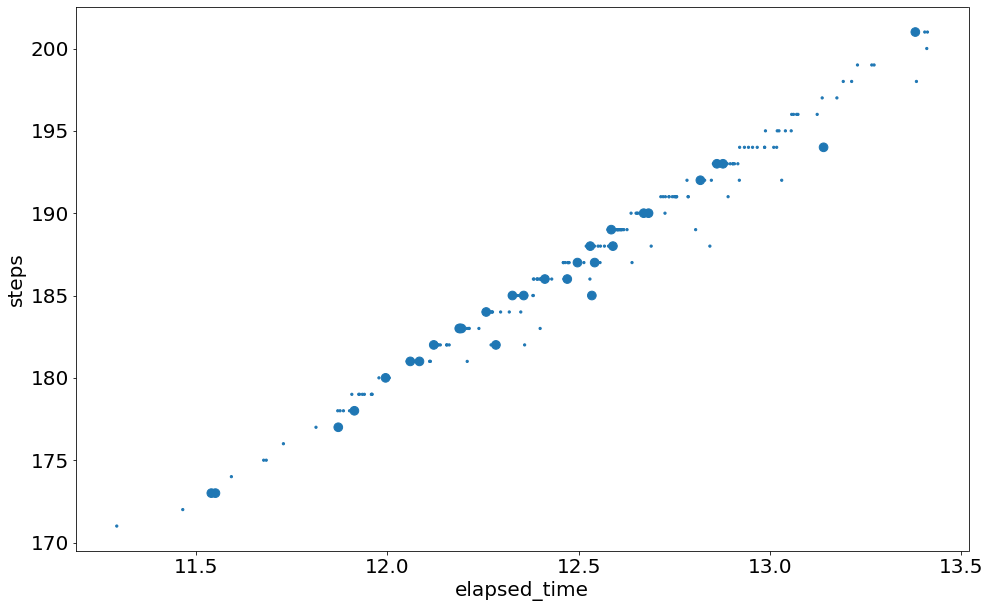

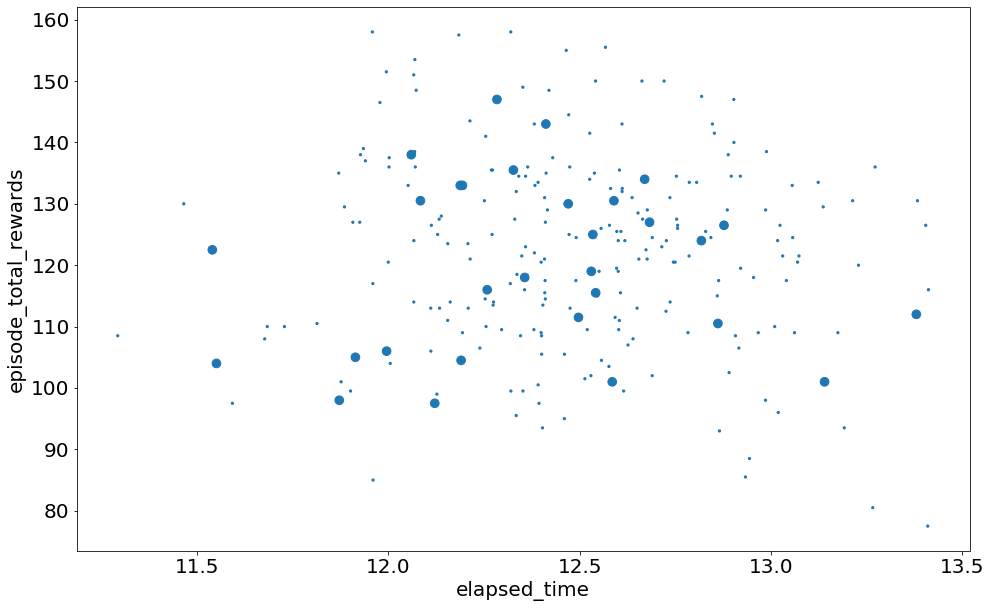

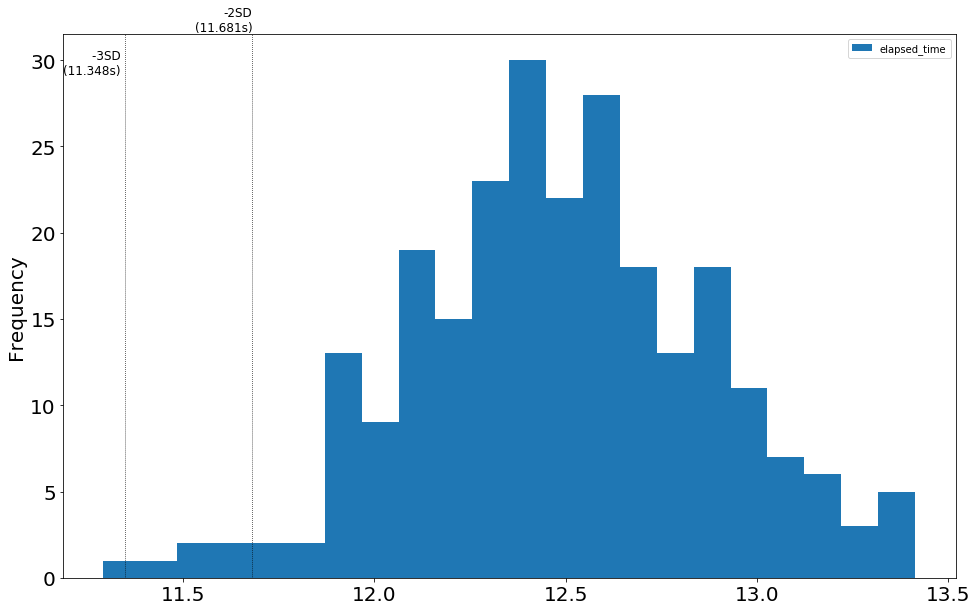

In [41]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
#df_slice = df_slice[df_slice['iteration'] <= 56]
max_iteration = df_slice['iteration'].max()

scatter_size = list()
for iter in df_slice['iteration']:
        if (iter > (max_iteration - 3)):
            scatter_size.append(75)
        else:
            scatter_size.append(5)
    
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=scatter_size, x='elapsed_time', y='steps')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=scatter_size, x='elapsed_time', y='episode_total_rewards')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    w = 0.1
    n = math.ceil((df_slice['elapsed_time'].max() - df_slice['elapsed_time'].min())/w)
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='hist', bins=n, x='steps', y='elapsed_time')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    data_minus2sd = np.percentile(df_slice['elapsed_time'], 2.28)
    data_minus3sd = np.percentile(df_slice['elapsed_time'], 0.13)

    print('Mean: %f' % (np.mean(df_slice['elapsed_time'])))
    print('Variance: %f' % (np.var(df_slice['elapsed_time'])))
    print('StdDev: %f' % (np.std(df_slice['elapsed_time'])))
    print('-2 StdDev: %f' % (data_minus2sd))
    print('-3 StdDev: %f' % (data_minus3sd))
    
    axes.axvline(x=data_minus2sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus2sd, axes.get_ylim()[1], '-2SD\n(%0.3fs)' % data_minus2sd, ha='right', va='bottom', size=12)

    axes.axvline(x=data_minus3sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus3sd, axes.get_ylim()[1], '\n-3SD \n(%0.3fs) ' % data_minus3sd, ha='right', va='top', size=12)


# Plot Action / Reward Distribution Heatmap on Track

In [42]:
def plot_x_top_speed_y_top_angle_on_track(df, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''

    x_highest_speed = 0.0
    if speed_index != 0:
        action_speed_list = action_speed
        action_speed_list.sort()
        x_highest_speed = action_speed_list[-speed_index]
        print('Speed - X Highest: X=%d (%f)' % (speed_index, x_highest_speed))

    y_highest_angle = 0.0
    if angle_index != 0:
        action_steering_list = action_steering
        action_steering_list.sort()
        y_highest_angle = action_steering_list[-angle_index]
        print('Absolute Angle - Y Highest: Y=%d (%f)' % (angle_index, y_highest_angle))
    
    if less_equal_angle >= 0:
        print('Absolute Angle - Less Or Equal: %d' % (less_equal_angle))
        
    if exact_angle != 0:
        print('Absolute Angle - Exact: %d' % (exact_angle))        

    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        throttle = row["throttle"]
        steer = row["steer"]
        
        if ((throttle == x_highest_speed) or (speed_index == 0)) and ((abs(steer) == y_highest_angle) or (angle_index == 0)) and ((abs(steer) <= less_equal_angle) or (less_equal_angle < 0)) and ((abs(steer) == exact_angle) or (exact_angle == 0)):
            if (plot_reward == True):
                track[y,x] = reward
            else:
                track[y,x] = 1
        
    fig = plt.figure(1, figsize=(plot_x_max/50, plot_y_max/50))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [43]:
def plot_x_top_speed_y_top_angle_on_track_for_iteration(curr_iteration, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward):
    max_iteration = sim_df['iteration'].max()
    if (curr_iteration == 0):
        curr_iteration = max_iteration
    df_slice = sim_df[sim_df['iteration']<=curr_iteration]
    df_slice = df_slice[df_slice['iteration']>(curr_iteration-5)]

    track = plot_x_top_speed_y_top_angle_on_track(df_slice, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(plot_y_max, plot_x_max), x_offset=x_offset, y_offset=y_offset)
    title_prefix = ''
    if (plot_reward == True):
        title_prefix = 'Reward '
    plt.title("%sDistribution for X Highest Speed & Y Highest Angle\nAngle Less or Eq to Z & Eq to W\nX: %d / Y: %d / Z: %d / W: %d" % (title_prefix, speed_index, angle_index, less_equal_angle, exact_angle))
    im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Load & Visualize Track Waypoints

In [44]:
# List the available tracks vs expected WORLD_NAME
print('WORLD_NAME: %s' % WORLD_NAME)
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
ListFiles
print('Available Tracks: %s' % ListFiles)

WORLD_NAME: Bowtie_track
Available Tracks: ['reInvent2019_track.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'AmericasGeneratedInclStart.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'Belille.npy', 'H_track.npy', 'reinvent_base.npy', 'Mexico_track.npy', 'Spain_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'Albert.npy', 'China_track.npy', 'LGSWide.npy', 'July_2020.npy', 'FS_June2020.npy', 'London_Loop_Train.npy', 'ChampionshipCup2019_track.npy']


In [45]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints(WORLD_NAME)
waypoints.shape

(163, 6)

In [46]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

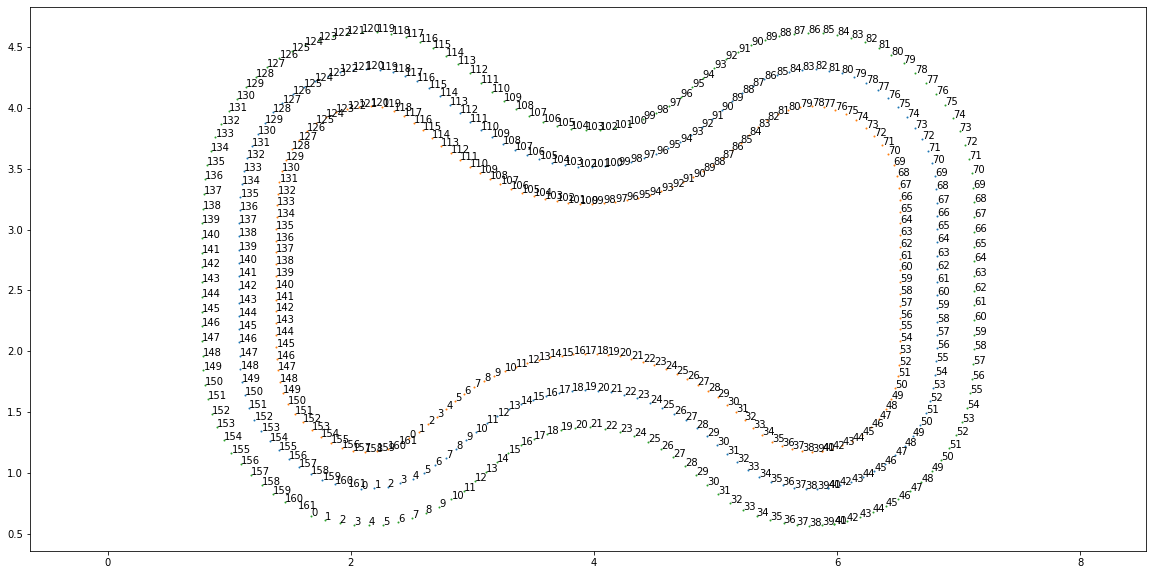

In [47]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

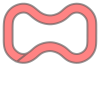

In [48]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

In [49]:
# rescale waypoints to centimeter scale
center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100

In [50]:
# add x_offset to bring everything to the positive axis

x_offset = int(sim_df['x'].min())
if x_offset > 0: # if positive, just keep it the same
    x_offset = 0
x_offset = abs(x_offset)

inner_border[:,:] = inner_border[:,:] + x_offset
center_line[:,:] = center_line[:,:] + x_offset
outer_border[:,:] = outer_border[:,:] + x_offset

In [51]:
# add y_offset to bring everything to the positive axis

y_offset = int(sim_df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset - x_offset
center_line[:,1] = center_line[:,1] + y_offset - x_offset
outer_border[:,1] = outer_border[:,1] + y_offset - x_offset

In [52]:
# track dimensions
track_x_max = outer_border[:,:].max()
track_y_max = outer_border[:,1].max()
print ('Track Dimensions: (%f, %f)' % (track_x_max, track_y_max))

# simulation dimensions
sim_x_max = sim_df['x'].max() + x_offset
sim_y_max = sim_df['y'].max() + y_offset
print ('Simulation Dimensions: (%f, %f)' % (sim_x_max, sim_y_max))

# plot dimensions
plot_x_max = int(math.ceil(max(track_x_max, sim_x_max)/50) * 50)
plot_y_max = int(math.ceil(max(track_y_max, sim_y_max)/50) * 50)
print ('Plot Dimensions: (%d, %d)' % (plot_x_max, plot_y_max))

Track Dimensions: (713.010285, 462.399494)
Simulation Dimensions: (724.440000, 485.930000)
Plot Dimensions: (750, 500)


In [53]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

# Plot Reward Distribution Heatmap on Track for the Most Recent Iteration
- Verify that we're not rewarding for bad driving behaviour
- Overlay a heatmap of rewards on the track to identify areas of improvement for the Reward Function; this could also highlight sections where the car is over- and under-steering, or where the car is not driving smoothly

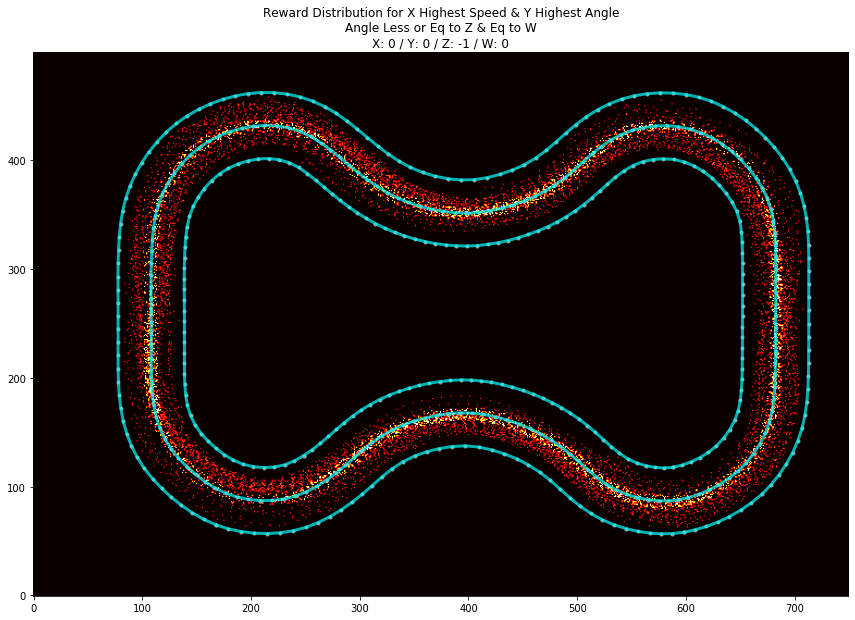

In [54]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, -1, 0, True)

# Plot Path Taken for the Fastest Completed Lap

In [55]:
def plot_top_laps(sorted_idx, n_laps=5, x_offset=0, y_offset=0, plot_yaw=False, plot_steer=False, plot_labels=False):
    fig = plt.figure(n_laps, figsize=(plot_x_max/50, plot_y_max/50*n_laps))
    for i in range(n_laps):
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        idx = sorted_idx[i]
        episode_data = sim_df[sim_df['episode']==idx]
        episode = sim_df_episodes[sim_df_episodes['episode']==idx]

        plt.title('Episode: %s (Iteration: %d, Episode-in-Iteration: %d), Steps: %d, Progress: %.2f, Rewards: %.2f, Elapsed Time: %.2fs, Status: %s' % (idx, episode['iteration'], episode['episode_in_iteration'], episode['steps'], episode['progress'], episode['episode_total_rewards'], episode['elapsed_time'], episode['status'].values[0]))
        for index, row in episode_data.iterrows():
            x1 = row['x']
            y1 = row['y']
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1+x_offset, car_x2+x_offset], [y1+y_offset, car_y2+y_offset], 'b.')
            
            if (plot_yaw):
                dx = 5*row['throttle']*math.cos(row['yaw']*math.pi/180)
                dy = 5*row['throttle']*math.sin(row['yaw']*math.pi/180)
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc='b', ec='b', zorder=99)
    
            if (plot_steer):
                dx = 5*row['throttle']*math.cos((row['yaw']+row['steer'])*math.pi/180)
                dy = 5*row['throttle']*math.sin((row['yaw']+row['steer'])*math.pi/180)
                if row['steer'] < 0:
                    steer_color = 'r'
                elif row['steer'] > 0:
                    steer_color = 'lime'
                else:
                    steer_color = 'y'
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc=steer_color, ec=steer_color, zorder=99)

            if (plot_labels):
                label_txt = '  STP: %s, WP: %s, HD:%0.2f, STR:%s, THR:%s' % (row['steps'], row['closest_waypoint'], row['yaw'], row['steer'], row['throttle'])
                plt.text(x1+x_offset, y1+y_offset, label_txt)
                print(label_txt)
    return fig



In [56]:
sim_df_episodes_fastest_full_lap = sim_df_episodes[sim_df_episodes['progress']>=100.0].sort_values('elapsed_time', ascending=True).head(1)
sim_df_episodes_fastest_full_lap

,iteration,episode_in_iteration,episode,steps,progress,status,episode_total_rewards,elapsed_time,start_time,end_time
20560,7,17,137,171,100.0,lap_complete,108.5,11.291785,1.605107e+09,1.605107e+09


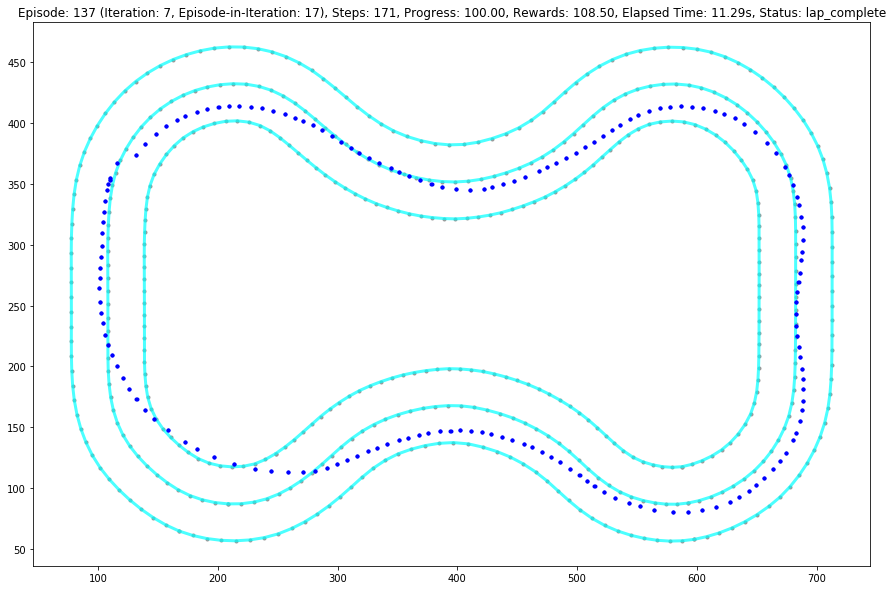

In [57]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset)

In [58]:
print('Done!')

Done!
